In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz
import utils.segs_viz as segs_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args
    
def downsample_affinities(affs, size, downsample_factor=2):
    affs = affs.view(1, size[0]*size[1], size[0], size[1])
    ds = downsample_factor
    N = size[0]*size[1]
    N_out = N // (ds**2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,size[0],size[1],-1).permute(0,3,1,2)
    affs = F.avg_pool2d(affs, kernel_size=[ds,ds], stride=ds)
    affs = affs.view(1,N_out,N_out).transpose(1,2)
    return affs    
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load some TDW preds and gt

In [106]:
results_dir = '/mnt/fs6/honglinc/eccv_2022_results/'
os.listdir(results_dir)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['TDW_Cylinder_MaskRCNN_RAFT',
 'TDW_MaskRCNN_Full',
 'TDW_Safari_EISEN_RAFT',
 'TDW_Cylinder_EISEN_RAFT',
 'TDW_Safari_MaskRCNN_RAFT',
 'TDW_MaskRCNN_RAFT',
 'TDW_EISEN_RAFT']

In [123]:
# results_path = os.path.join(results_dir, 'TDW_MaskRCNN_RAFT')
results_path = os.path.join(results_dir, 'TDW_EISEN_RAFT')
results = sorted(os.listdir(results_path))
results[0:5]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['model_split_0-0009.pt',
 'model_split_0-0019.pt',
 'model_split_0-0029.pt',
 'model_split_0-0039.pt',
 'model_split_0-0049.pt']

In [124]:
ex = 1
data = torch.load(results_path + '/' + results[ex])
for k,v in data.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape, v.dtype)
    else:
        print(k, "list len %d" % len(v), v[0].shape, v[0].dtype)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


image torch.Size([3, 512, 512]) torch.uint8
affinities torch.Size([1, 16384, 16384]) torch.float32
pred_segments list len 3 (512, 512) bool
gt_segments list len 3 (512, 512) bool


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


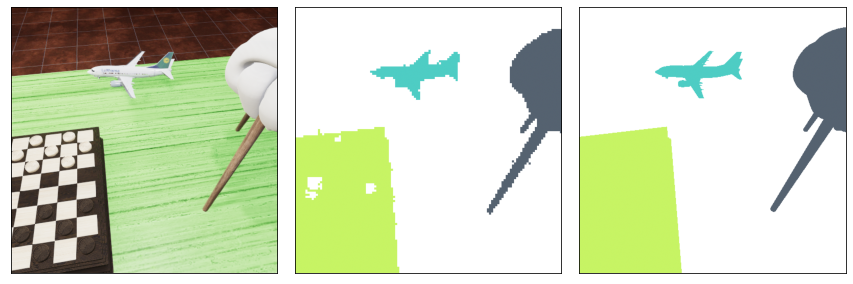

In [125]:
segs_viz.plot_image_pred_gt_segments(data, figsize=(12,4), cmap=3, bg_color=(255,255,255),
#                                      save_path='/home/dbear/tdw_image_pred_gt.svg')
                                    )

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


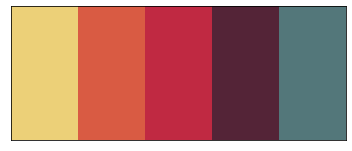

In [94]:
segs_viz.plot_palette(i=2)

## Compare EISEN to a baseline

In [133]:
from tqdm import tqdm

ex = 2
models = ['TDW_EISEN_RAFT', 'TDW_MaskRCNN_RAFT']

## get images, gts, preds
img = gts = None
preds = {}
for i,m in enumerate(tqdm(models)):
    results_path = os.path.join(results_dir, m)
    results = sorted(os.listdir(results_path))
    data = torch.load(os.path.join(results_path, results[ex]))
    
    if i == 0:
        img = data['image']
        gts = data['gt_segments']
    
    preds[m] = data['pred_segments']
    


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2/2 [00:07<00:00,  3.53s/it]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TDW_EISEN_RAFT model_split_0-0029.pt


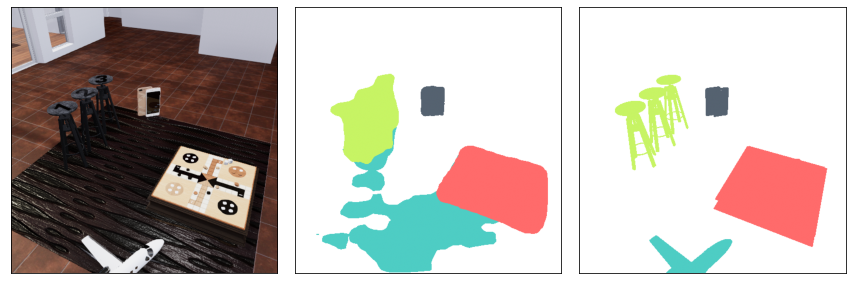

TDW_MaskRCNN_RAFT model_split_0-0029.pt


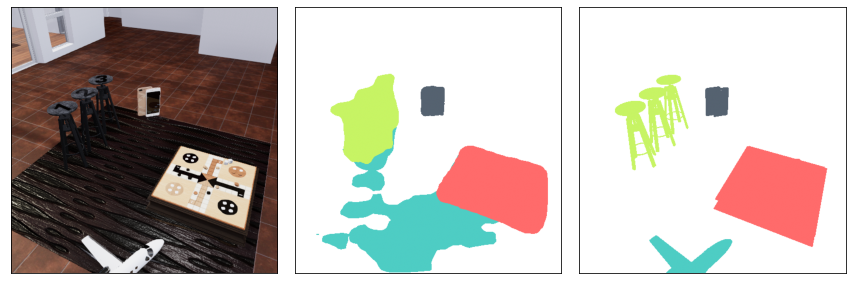

In [134]:
for m in models:
    print(m, results[ex])
    d = {'image': img, 'gt_segments': gts, 'pred_segments': preds[m]}
    segs_viz.plot_image_pred_gt_segments(data, figsize=(12,4), cmap=3, bg_color=(255,255,255))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


ValueError: 3 is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cmo.algae', 'cmo.algae_r', 'cmo.amp', 'cmo.amp_r', 'cmo.balance', 'cmo.balance_r', 'cmo.curl', 'cmo.curl_r', 'cmo.deep', 'cmo.deep_r', 'cmo.delta', 'cmo.delta_r', 'cmo.dense', 'cmo.dense_r', 'cmo.diff', 'cmo.diff_r', 'cmo.gray', 'cmo.gray_r', 'cmo.haline', 'cmo.haline_r', 'cmo.ice', 'cmo.ice_r', 'cmo.matter', 'cmo.matter_r', 'cmo.oxy', 'cmo.oxy_r', 'cmo.phase', 'cmo.phase_r', 'cmo.rain', 'cmo.rain_r', 'cmo.solar', 'cmo.solar_r', 'cmo.speed', 'cmo.speed_r', 'cmo.tarn', 'cmo.tarn_r', 'cmo.tempo', 'cmo.tempo_r', 'cmo.thermal', 'cmo.thermal_r', 'cmo.topo', 'cmo.topo_r', 'cmo.turbid', 'cmo.turbid_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

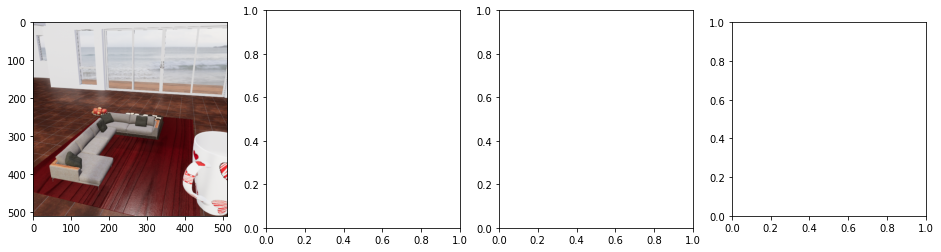

In [137]:
out = segs_viz.compare_models(results_dir, models, ex=0, cmap=3)